In [1]:
#Import all the nessesary modules
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
# widgest allows interactive elements 
import ipywidgets as widgets


import sys
import os
sys.path.insert(0, os.path.abspath('Support'))

# Visualizer
from Renderer import *

# 1. Bicycle Kinematic Model

The configuration (also known as state) of the bycycle is descibed by its 2D position and orientation, i.e., $(x, y, \theta)$. The control inputs are the speed at the rear wheel and the steering angle at the front wheel, i.e., $(v, \delta)$

In the following we implement the bicycle kinematic model and show how its motion is described in the world frame.

In [2]:
# Define Bicycle model

class Bicycle(object):
    """Implementation of the kinematic bicycle model (rear wheel model)
    length = distance (in meters) between the wheels
    gamma_max = maximum steering angle
    speed_max = maximum speed
    """

    def __init__(self, length=1, delta_max=np.pi/3, vel_max=5):
        
        # Length between the wheels
        self.length = length
        
        # Maximum velocity and steering angle
        self.delta_max = delta_max
        self.vel_max = vel_max
        
        # Configuration of bicycle in world frame, x=forward, y=lateral, theta=orientation
        self.x = 0                      
        self.y = 0                      
        self.theta = 0                  
        self.states = []
        
        # Initial control inputs
        self.velocity = 0
        self.steering = 0
        
        self.v_slider = widgets.FloatSlider(value=self.velocity, min=-self.vel_max, max=self.vel_max, step=0.1, 
                                            description=r'Velocity ($v$)',
                                            continuous_update=True, orientation='horizontal',
                                            readout=True, readout_format='.1f')
        self.delta_slider = widgets.FloatSlider(value=0, min=-1, max=1, step=0.05, 
                                                description=r'Steering ($\delta$)', 
                                                continuous_update=True, orientation='horizontal',
                                                readout=True, readout_format='.1f')
        
        ui = widgets.HBox([self.v_slider, self.delta_slider])
        
        self.control_widgets = widgets.interactive_output(self.update_control, {'v': self.v_slider, 
                                                                                'delta_ratio': self.delta_slider})
        display(ui, self.control_widgets)
        
                
    def update_control(self, v, delta_ratio):
        self.velocity = np.clip(v, -self.vel_max, self.vel_max)
        delta = delta_ratio * self.delta_max
        self.delta = np.clip(delta, -self.delta_max, self.delta_max)
           
    def reset(self):
        first_state = self.states[0]
        self.x, self.y, self.theta = first_state
        self.velocity = self.v_slider.value
        self.steering = self.delta_slider.value
        del self.states[:]
        self.states = [first_state]
    
    def get_state(self):
        """Return the current bicycle state. The state is in (x,y,theta) format"""
        return (self.x, self.y, self.theta)
    
    def set_state(self,x=0,y=0,theta=0):
        """Sets the model new state"""
        self.x = x
        self.y = y
        self.theta = theta
        self.states.append((x, y, theta))
    
    def drive(self, dt=0.01):
        """
        Update the bicycle state.
        """        
        # Compute velocity using control input and current orientation
        v_x = self.velocity * np.cos(self.theta)
        v_y = self.velocity * np.sin(self.theta)
        
        # Compute next position
        next_x = self.x + v_x * dt
        next_y = self.y + v_y * dt
                
        # Compute angular velocity given control input (velocity and
        # steering angle)
        omega = self.velocity * np.tan(self.delta) / self.length
        
        # Compute next orientation
        next_theta = self.theta + omega * dt
        self.set_state(next_x, next_y, next_theta)

## Lets now test driving the bicycle
- Use the slider to adjust the velocity and steering angle
- Currently the animation will play for 60 frames. You can adjust this number by providing the ```max_iterations``` argument to the function call ```rend.initialize(bot, max_iterations=[integer])```

Output()

<IPython.core.display.Javascript object>


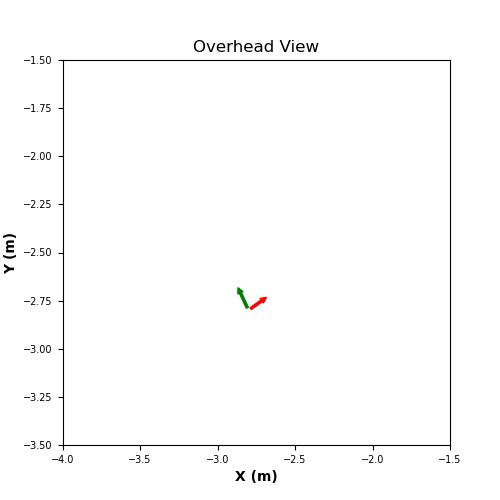

In [3]:
# Test driving the robot

# Create a bicycle with .25 m between the rear and front wheel
bot = Bicycle(length=0.25)
# Place the robot at -2.8,-2.8 which is bottom middle of our arena
bot.set_state(-2.8, -2.8, np.pi/6)

%matplotlib notebook
rend = Renderer.Instance()

# TODO: Add message describing the output that can be given to the initialize method
rend.initialize(bot, dt_data=0.02)

**FLUX Question (1pt)**: What trajectory does the bicycle follow if we provide the following sequence of  control inputs:
- velocity = 2.7, steering angle = 0.8 at frame 0
- velocity = 2.7, steering angle = -0.8 at frame 30?

**FLUX Question (1pt)**: Given the relationship between the radius of curvature $R$ and the steering angle $\delta$ (as shown in the image below), what steering angle should be given as input if we want the bicycle to travel a circle of radius 5m?

<img src=Support/images/fluxQuestion2.png width="400" height="500">

# 2. PenguinPi Kinematic Model

<img src=https://cirrusrobotics.com.au/images/products/penguinpi/front_a.jpg width="400" height="500">


The state of the robot is described by its 2D position $(x,y)$  and orientation $\theta$. Our control inputs are the linear and angular velocity of the robot, i.e., $v$ and $\omega$. 

We will define the <code>drive(self, dt=0.02)</code> function that will update the state of the robot given a sequence of control inputs.

**Interaction**
- Move the sliders to change the control inputs

**TODO**
- Find the code error
- Complete the code that makes the robot turn

In [4]:
class PenguinPi(object):
    
    def __init__(self, max_v=5, max_omega=np.pi):
        
        # Robot state
        self.x = 0
        self.y = 0
        self.theta = 0
        
        # List of all PenguiPi states in current simulation and wheel speeds
        self.states = []
        
        # Control inputs
        self.linear_velocity = 0
        self.angular_velocity = 0
        
        # Control input bounds
        self.max_linear_velocity = max_v
        self.max_angular_velocity = max_omega
                
        # Create widgets to adjust control inputs during simulation        
        self.linear_slider = widgets.FloatSlider(value=0, min=-self.max_linear_velocity, 
                                                 max=self.max_linear_velocity, step=0.1, 
                                                 description=r'$v$', continuous_update=False, 
                                                 orientation='horizontal', readout=True, readout_format='.1f')
        self.angular_slider = widgets.FloatSlider(value=0, min=-self.max_angular_velocity, 
                                                  max=self.max_angular_velocity, step=0.1, 
                                                  description=r'$\omega$', 
                                                  continuous_update=False, orientation='horizontal',
                                                  readout=True, readout_format='.1f')
        
        ui = widgets.HBox([self.linear_slider, self.angular_slider])
        
        self.control_widgets = widgets.interactive_output(self.update_control, {'linear_v': self.linear_slider, 
                                                                                'angular_v': self.angular_slider})
        display(ui, self.control_widgets)
        
                          
    def drive(self, dt=0.02):
        """
         Update the PenguiPi state
        """        
        
        # Remember that the PenguiPi current state is given by self.x, self.y, self.theta        
        # Apply the velocities
        if self.angular_velocity == 0:

            next_x = self.x + np.cos(self.theta)*self.linear_velocity*dt
            next_y = self.y + np.sin(self.theta)*self.linear_velocity*dt
            next_theta = self.theta
        else:
            next_theta = self.theta + self.angular_velocity * dt
            
            R = self.linear_velocity/self.angular_velocity
            
            next_x = self.x + R * (-np.sin(self.theta) + np.sin(next_theta))
            next_y = self.y + R * (np.cos(self.theta)  - np.cos(next_theta))
       
        # Make next state our current state
        self.set_state(next_x, next_y, next_theta)        
        
    def update_control(self, linear_v, angular_v):
        # We read the values from the sliders and update the robot's linear and angular velocity
        self.linear_velocity = np.clip(linear_v, -self.max_linear_velocity, self.max_linear_velocity)
        self.angular_velocity = np.clip(angular_v, -self.max_angular_velocity , self.max_angular_velocity)
           
    def reset(self):
        # We bring the robot to its initial state and set control to default values
        # This method is called after a click in the "reset" button or when the max. number of display 
        # iterations is reached
        first_state = self.states[0]
        self.x, self.y, self.theta = first_state
        self.linear_velocity = self.linear_slider.value
        self.angular_velocity = self.angular_slider.value
        del self.states[:]
        self.states = [first_state]
    
    def get_state(self):
        """Return the current robot state. The state is in (x,y,theta) format"""
        return (self.x, self.y, self.theta)
    
    def set_state(self,x=0,y=0,theta=0):
        """Define the new model state"""
        self.x = x
        self.y = y
        self.theta = theta
        self.states.append((x, y, theta))

## Lets now test driving the PenguiPi
- Use the slider to adjust the velocity and steering angle
- Currently the animation will play for 60 frames. You can adjust this number by providing the ```max_iterations``` argument to the function call ```rend.initialize(bot, max_iterations=[integer])```

Output()

<IPython.core.display.Javascript object>


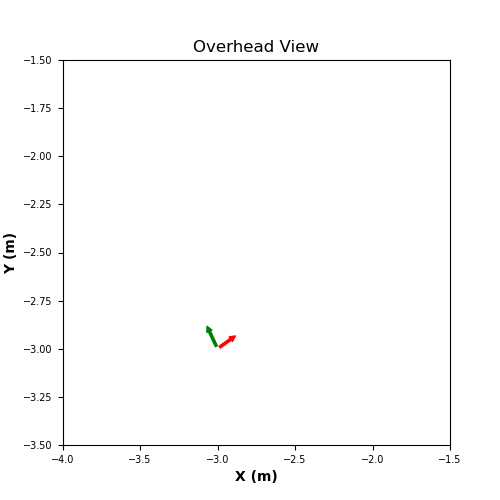

In [5]:
# Test driving the robot
# Creater a new PenguinPi object
pi_bot = PenguinPi()
# Place the robot at -3.0,-3.0 which is bottom middle of our arena
pi_bot.set_state(-3.0, -3.0, np.pi/6)

# Instantiate rendenring object
rend = Renderer.Instance()
rend.initialize(pi_bot, dt_data=0.02)

**FLUX Question**: Where was the coding error?

# 2. Coding exercises

### Exercise 1 (2pts): Determine the Location of the Front Wheel 
    
<img src=Support/images/bicycle.png width="300" height="350">

Given the known 2D location of the centre of the rear wheel of the bicycle ($x$, $y$), determine the location of the centre of the front wheel ($x_f, y_f$) in the world frame. 

**Input**:
- 1D array of shape 2x1 with the location of the rear wheel (rear_wheel_loc)
- Orientation of the bicycle in radians (theta)
- Bicycle length (length)

**Output**:
- 1D array of shape 2x1 with the location of the front wheel in the world frame (values should not be rounded)

In [6]:
def get_front_wheel_location(rear_wheel_loc=np.zeros(2), theta=0, length=0):
    
    front_wheel_loc = np.zeros(2)
    
    front_wheel_loc[0] = rear_wheel_loc[0] + length * np.cos(theta)
    front_wheel_loc[1] = rear_wheel_loc[1] + length * np.sin(theta)
    
    return front_wheel_loc

**Test your code**

We have included a plot function ``display_bycicle_wheels`` to help you verify your answers. The function will display two frames, one to represent the rear wheel (red) and another to represent the front wheel (blue). Similarly, the function assumes that the steering angle $\delta$ is set to zero. Here is an example of how to use it

```python 
from TestingRenderer import display_bicycle_wheels

rear_wheel = np.ones(2)
theta_angle = np.pi/2
front_wheel = get_front_wheel_location(rear_wheel_loc=rear_wheel, theta=theta_angle, length=1)

display_bicycle_wheels(rear_wheel, front_wheel, theta=theta_angle)

```
As visual test cases, we recommend to consider:

- Where should be the front wheel if $\theta=0$?
- Where should be the front wheel if $\theta=\frac{\pi}{2}$?

<IPython.core.display.Javascript object>


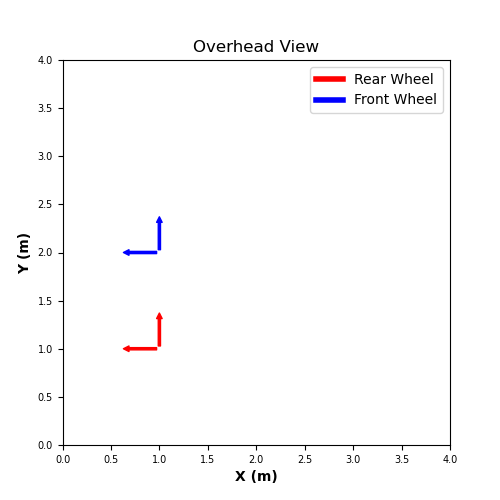

In [7]:
from TestingRenderer import display_bicycle_wheels

rear_wheel = np.ones(2)
theta_angle = np.pi/2
front_wheel = get_front_wheel_location(rear_wheel_loc=rear_wheel, theta=theta_angle, length=1)

display_bicycle_wheels(rear_wheel, front_wheel, theta=theta_angle)

### Exercise 2 (2pts): Extend Bicycle Model to Consider Steering Angle Rate
    
In the example of the bicycle model, the bicycle took as input velocity $v$ and steering angle $\delta$.

We now want to modify our model so that it receives velocity $v$ and steering rate $\varphi$ as control inputs instead. With this new control input, the bicycle state is now defined by its 2D position $(x,y)$,  orientation ($\theta$) and steering angle ($\delta$).

You are tasked with computing the bicycle state for a total of $max\_T$ iterations using this new control input.

**Input**:
- 1D array with the current bicycle state $[x, y, \theta, \delta]$
- Bicycle length (length)
- Maximum number of iterations (max_t)
- Velocity (v)
- Steering_rate (phi)


**Output**:
- Array of bicycle states of lenght max_t. Column order must be $[x, y, \theta, \delta]$ (values should not be rounded)

In [8]:
def get_bicycle_trajectory(initial_state = np.array([1, 1, 0, 0]), length=1, max_it=100, v=0, phi=0):
    
    dt = 0.05
    states = np.zeros((max_it+1, initial_state.shape[0]))
    states[0,:] = initial_state
    
    for i in range(1, max_it):
        v_x = v * np.cos(states[i-1][2]) # velocity * np.cos(self.theta) 
        v_y = v * np.sin(states[i-1][2]) # velocity * np.sin(self.theta) 
        
        x_next = states[i-1][0] + v_x * dt
        y_next = states[i-1][1] + v_y * dt
        
        delta_next = states[i-1][3] + phi * dt
        
        omega = v * np.tan(delta_next) / length
        
        next_theta = states[i-1][2] + omega * dt
        
        states[i, :] = [x_next, y_next, next_theta, delta_next]
        
    return states

**Test your code**

We have included a rendering class to help you verify your answers. Here is an example of how to use it:

```python 
from TestingRenderer import TestingRenderer

a = get_bicycle_trajectory(initial_state=np.array([5, -5, np.pi/4, 0.1]), max_it=500, v=2.3, phi=0.01)

testRenderer = TestingRenderer.Instance()
testRenderer.initialize(a, dt_data=0.05)

```
As visual test cases, we recommend you to keep in mind that:

- The bicycle should move in a straight line if $\theta=0$, $\delta=0$, and $\varphi=0$
- The bicycle should move in a circular trajectory if $\theta \ne0$, $\delta \ne 0$, and $\varphi=0$
- The bicycle should move in a spiral trajectory if $\theta \ne0$, $\delta \ne 0$, and $\varphi\ne0$

<IPython.core.display.Javascript object>


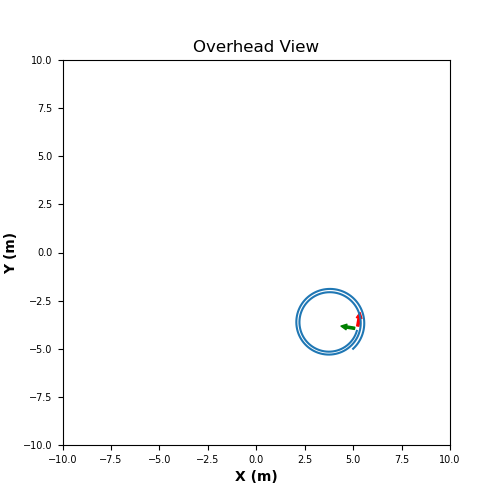

In [12]:
from TestingRenderer import TestingRenderer

a = get_bicycle_trajectory(initial_state=np.array([5, -5, np.pi/4, 0.5]), max_it=500, v=2.3, phi=0.01)

testRenderer = TestingRenderer.Instance()
testRenderer.initialize(a, dt_data=0.05)

### Exercise 3 (3pts): Differential Drive Kinematic Model

Let us consider a two-wheeled vehicle that has as control inputs the rotation rate of the wheels. 

<img src=Support/images/differentialDrive.png width="300" height="350">

Given the kinematic constraints that relate the wheel rotation rates to the linear and angular velocity of the PenguiPi robot: 

$$
\begin{align}
v=\frac{rw_1 + rw_2}{2} \\
\omega=\frac{rw_1 - rw_2}{l},
\end{align}
$$

compute the state, i.e., $[x, y, \theta]$ of the PenguiPi robot for a total of $𝑚𝑎𝑥\_𝑇$ iterations using this new control input.

**Input**:
- 1D array with the current robot state $[x, y, \theta]$
- Wheels width (length)
- Wheels radius (wheel_radius)
- Maximum number of iterations (max_t)
- Rotation rate of the right wheel (right_rate)
- Rotation rate of the left wheel (left_rate)

**Output**:
- Array of robot states of lenght max_t. Column order must be $[x, y, \theta]$ (values should not be rounded)

In [10]:
def get_penguipi_trajectory(initial_state = np.array([1, 1, 0]), length=1, wheel_radius=0.1,
                            right_rate=0, left_rate=0, max_it=100):
    
    dt = 0.2
    states = np.zeros((max_it+1, initial_state.shape[0]))
    states[0, :] = initial_state
    
    # calculate velocities
    v = wheel_radius * (right_rate + left_rate) / 2
    w = wheel_radius * (right_rate - left_rate) / length
    
    for i in range(1, max_it):
        
        if w == 0:
            x_next = states[i-1][0] + v * dt
            y_next = states[i-1][1] + v * dt
            next_theta = states[i-1][2]
        else:
            next_theta = states[i-1][2] + w * dt
            
            R = v/w
            
            x_next = states[i-1][0] + R * (-np.sin(states[i-1][2]) + np.sin(next_theta))
            y_next = states[i-1][1] + R * (np.cos(states[i-1][2])  - np.cos(next_theta))
            
        
        states[i, :] = [x_next, y_next, next_theta]
      
    return states

**Test your code**

We have included a rendering class to help you verify your answers. Here is an example of how to use it:

```python 
from TestingRenderer import TestingRenderer

a = get_penguipi_trajectory(initial_state=np.array([0, -5, np.pi/6]), max_it=500, right_rate=20, 
                            left_rate=10)
testRenderer = TestingRenderer.Instance()
testRenderer.initialize(a, dt_data=0.05)

```
As visual test cases, we recommend you to keep in mind that:

- The PenguiPi robot should move in a straight line if $w_1=w_2$
- The PenguiPi robot should turn to the left if $w_1>w_2$ (the right wheel moves faster than the left wheel)
- The PenguiPi robot should turn to the right if $w_1<w_2$ (the left wheel moves faster than the right wheel)

<IPython.core.display.Javascript object>


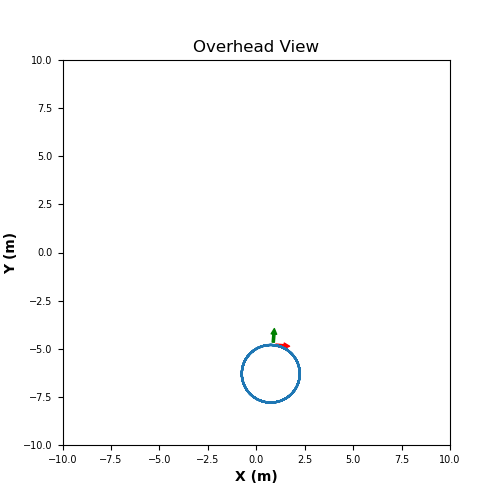

In [11]:
from TestingRenderer import TestingRenderer

a = get_penguipi_trajectory(initial_state=np.array([0, -5, np.pi/6]), max_it=500, right_rate=10, 
                            left_rate=20)
testRenderer = TestingRenderer.Instance()
testRenderer.initialize(a, dt_data=0.05)